# OpenAI Gym Atari: Breakout / Keras-RL  

The original code from https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py

### Jupyter Notebook

* Python 3.6 
* Tensorflow 1.9 
* Keras 2.1.6 
* Keras-RL 0.4.2 


In [2]:
from PIL import Image
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint


INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

ENV_NAME = 'BreakoutDeterministic-v4'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

model = Sequential()


model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
#print(model.summary())

memory = SequentialMemory(limit=100000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=100000)

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=5000, gamma=.99, target_model_update=1000,
               train_interval=4, delta_clip=1.)

dqn.compile(Adam(lr=.00025), metrics=['mae'])

### Train and Save Weights

In [ ]:
weights_filename = 'dqn_{}_weights.h5f'.format(ENV_NAME)
checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(ENV_NAME)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=20000)]
callbacks += [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=100000, log_interval=10000)

dqn.save_weights(weights_filename, overwrite=True)
dqn.test(env, nb_episodes=1, visualize=False)

### Test and Visualize on Jupyter Notebook

Episode 1: reward: 37.000, steps: 1185
END


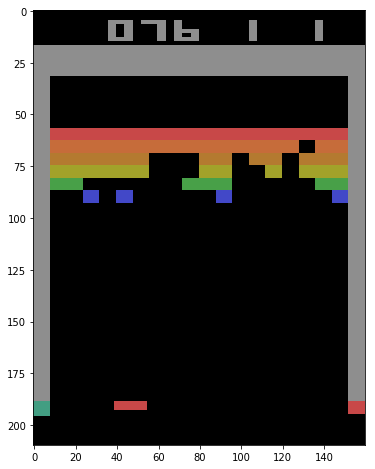

In [4]:
from rl.callbacks import Callback
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# Subclass to visualize on Jupyter Notebook, inherits from rl.callbacks.Callback Class
class Render(Callback):
    def on_step_end(self, step, logs={}):
        plt.clf()
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

weights_filename = 'dqn_{}_weights.h5f'.format(ENV_NAME)
#weights_filename = 'dqn_{}_weights_1750000.h5f'.format(ENV_NAME) # @checkpoint
dqn.load_weights(weights_filename)

callbacks = Render()
plt.figure(figsize=(6,8))
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])

env.close()
print('END')

### Another Option to Visualize as ArtistAnimation and Save as GIF animation

In [19]:
from rl.callbacks import Callback
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

ims = []

class Render(Callback):
    def on_step_end(self, step, logs={}):
        im = plt.imshow(env.render(mode='rgb_array'))
        ims.append([im])

weights_filename = 'dqn_{}_weights_1750000.h5f'.format(ENV_NAME)
dqn.load_weights(weights_filename)

callbacks = Render()
fig = plt.figure(figsize=(4,5))
plt.axis('off')
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])

ani = animation.ArtistAnimation(fig=fig, artists=ims, interval=10)
# ani.save("anim.gif", writer = "imagemagick")
plt.close()

HTML(ani.to_jshtml())         # JavascriptHTML output
#HTML(ani.to_html5_video())   # HTML5 Video output

Testing for 1 episodes ...
Episode 1: reward: 37.000, steps: 1185
